In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# %matplotlib inline
plt.style.use("ggplot")
import plotly.graph_objects as go

import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [ ]:
class PipelineRecommendation():
    def __init__(self):
        self.project = 'churn prediction '

    def get_percent_missing(self, df):
        percent_missing = df.isnull().sum() * 100 / len(df)
        missing_value_df = pd.DataFrame({'column_name': df.columns,
                                             'percent_missing': percent_missing})
        missing_value_df.sort_values('percent_missing', inplace=True)
        percent_missing = df.isnull().sum() * 100 / len(df)

        print('Percentage of Missing Values: ')

        return percent_missing


    def unique_counts(self, df):
        """
        Returns the number of unique values and unique values for each feature in the given dataframe.

        Parameters:
        df (pandas.DataFrame): The input dataframe.

        Returns:
        unique_counts_df (pandas.DataFrame): A dataframe containing the feature names, the number of unique values, the unique values, and the data type of each feature.
        """
        unique_counts = df.nunique()
        unique_values = [df[column].unique() for column in df.columns]
        data_types = [str(df[column].dtype) for column in df.columns]
        unique_counts_df = pd.DataFrame({'feature': df.columns, 'unique_count': unique_counts, 'unique_values': unique_values, 'data_type': data_types})
        return unique_counts_df


    def dataframe_insights(self, df):
        """
        This function provides basic insights about a dataframe.

        Parameters:
        df (pandas dataframe): The dataframe to analyze.

        Returns:
        A dictionary containing basic insights about the dataframe.
        """
        insights = {}
        insights['Number of records'] = len(df)
        insights['Number of columns'] = len(df.columns)
        insights['Columns'] = list(df.columns)
        insights['Number of unique values in each column'] = df.nunique().to_dict()
        insights['Missing values'] = df.isnull().sum().sum()
        insights['Percentage of missing values in each column'] = (df.isnull().sum() / len(df) * 100).round(2).to_dict()
        insights['Data types'] = df.dtypes.to_dict()
        insights['Summary statistics'] = df.describe().to_dict()
        insights['Correlation matrix'] = df.corr().to_dict()
        insights['Number of duplicated rows'] = len(df[df.duplicated()])
        insights['Duplicate rows'] = list(df[df.duplicated(keep=False)].sort_values(by=list(df.columns)).to_dict('index').values())
        return insights

In [ ]:
recommendation = PipelineRecommendation()

In [ ]:
amazon_ratings = pd.read_csv('/content/ratings_Beauty.csv')
amazon_ratings['user_id'] = pd.factorize(amazon_ratings['UserId'])[0]
# amazon_ratings = amazon_ratings.sort_values(by = 'UserId', ascending = False)
amazon_ratings.head(5)

,UserId,ProductId,Rating,Timestamp,user_id
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200,0
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200,1
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200,2
3,A1WMRR494NWEWV,0733001998,4.0,1382572800,3
4,A3IAAVS479H7M7,0737104473,1.0,1274227200,4


In [ ]:
recommendation.unique_counts(amazon_ratings)

,feature,unique_count,unique_values,data_type
UserId,UserId,1210271,"[A39HTATAQ9V7YF, A3JM6GV9MNOF9X, A1Z513UWSAAO0...",object
ProductId,ProductId,249274,"[0205616461, 0558925278, 0733001998, 073710447...",object
Rating,Rating,5,"[5.0, 3.0, 4.0, 1.0, 2.0]",float64
Timestamp,Timestamp,4231,"[1369699200, 1355443200, 1404691200, 138257280...",int64
user_id,user_id,1210271,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",int64


In [ ]:
recommendation.get_percent_missing(amazon_ratings)

Percentage of Missing Values: 


,0
UserId,0.0
ProductId,0.0
Rating,0.0
Timestamp,0.0
user_id,0.0


In [ ]:
numeric_df = amazon_ratings.select_dtypes(include=['number'])
recommendation.dataframe_insights(numeric_df)

{'Number of records': 2023070,
 'Number of columns': 3,
 'Columns': ['Rating', 'Timestamp', 'user_id'],
 'Number of unique values in each column': {'Rating': 5,
  'Timestamp': 4231,
  'user_id': 1210271},
 'Missing values': np.int64(0),
 'Percentage of missing values in each column': {'Rating': 0.0,
  'Timestamp': 0.0,
  'user_id': 0.0},
 'Data types': {'Rating': dtype('float64'),
  'Timestamp': dtype('int64'),
  'user_id': dtype('int64')},
 'Summary statistics': {'Rating': {'count': 2023070.0,
   'mean': 4.149035871225415,
   'std': 1.311504573702341,
   'min': 1.0,
   '25%': 4.0,
   '50%': 5.0,
   '75%': 5.0,
   'max': 5.0},
  'Timestamp': {'count': 2023070.0,
   'mean': 1360388736.5637374,
   'std': 46118604.21685982,
   'min': 908755200.0,
   '25%': 1350259200.0,
   '50%': 1372809600.0,
   '75%': 1391472000.0,
   'max': 1406073600.0},
  'user_id': {'count': 2023070.0,
   'mean': 503609.29144863994,
   'std': 353574.97991265875,
   'min': 0.0,
   '25%': 189536.0,
   '50%': 455792.0,

In [ ]:
# Calculate the frequency of ratings
rating_counts = amazon_ratings['Rating'].value_counts().sort_index()

# Create the bar chart using Plotly
fig = go.Figure(data=go.Bar(x=rating_counts.index, y=rating_counts.values))

# Customize the chart layout and style
fig.update_layout(
    title='Frequency of Ratings',
    xaxis_title='Rating',
    yaxis_title='Frequency',
    xaxis=dict(type='category'),
    yaxis=dict(type='linear'),
    plot_bgcolor='white',  # Set the background color
    bargap=0.2,  # Set the gap between bars
    bargroupgap=0.1,  # Set the gap between groups of bars
    font=dict(
        family='Arial',  # Set the font family
        size=14,  # Set the font size
        color='black'  # Set the font color
    )
)

# Display the chart
fig.show()

In [ ]:
# Calculate average rating for each product
product_ranking = amazon_ratings.groupby(['ProductId'])['Rating'].mean().reset_index().sort_values(by = 'Rating', ascending=False)
product_ranking

,ProductId,Rating
249272,B00LPVG6V0,5.0
9,1304146537,5.0
249273,B00LU0LTOU,5.0
0,0205616461,5.0
10,130414674X,5.0
...,...,...
120825,B004JGDN3W,1.0
120814,B004JFGAXI,1.0
204117,B00B4UAHUI,1.0
61760,B001GLRFPU,1.0


In [ ]:
# Create a distribution chart using Plotly
fig = go.Figure(data=[go.Histogram(x=product_ranking['Rating'], nbinsx=10)])

fig.update_layout(
    title="Average Rating Distribution",
    xaxis_title="Rating",
    yaxis_title="Count",
    bargap=0.1,
    bargroupgap=0.1
)

fig.update_traces(marker_color='rgba(50, 171, 96, 0.6)')

fig.show()

In [ ]:
products_ratings = amazon_ratings.pivot_table(index='ProductId', columns='Rating', values='Timestamp', aggfunc='count', fill_value=0)
products_ratings.columns = ['Rating ' + str(col) for col in products_ratings.columns]
products_ratings['Frequency'] = products_ratings.sum(axis=1)
# products_ratings = products_ratings.sort_values('Frequency', ascending=False)

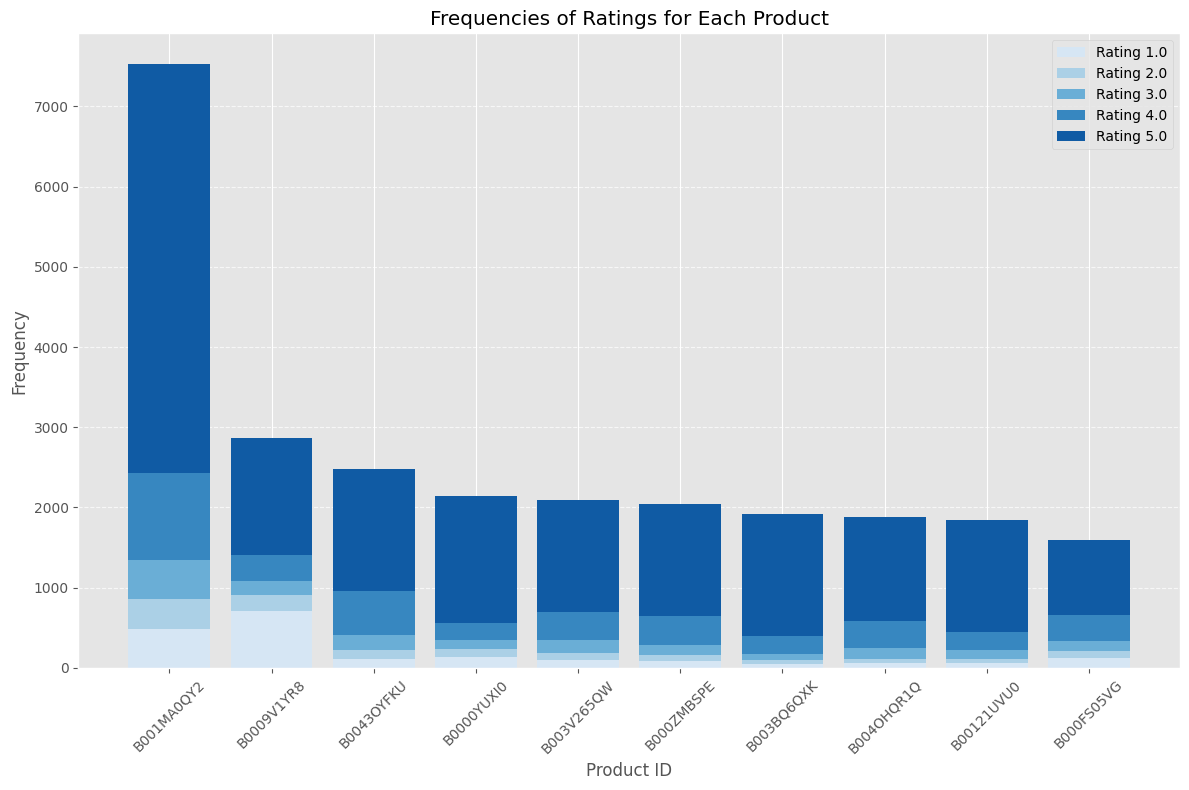

In [ ]:
# Extract data from the dataframe
df = products_ratings.sort_values('Frequency', ascending=False).head(10)

ratings = df[['Rating 1.0', 'Rating 2.0', 'Rating 3.0', 'Rating 4.0', 'Rating 5.0']].values
product_ids = df.index.values

# Define a blue color palette
colors = sns.color_palette('Blues', n_colors=5)

# Plot the bar chart with a white background
plt.figure(figsize=(12, 8), facecolor='w')
for i in range(5):
    plt.bar(product_ids, ratings[:, i], bottom=ratings[:, :i].sum(axis=1), color=colors[i], label='Rating ' + str(i+1) + '.0')

# Customize the plot
plt.xlabel('Product ID')
plt.ylabel('Frequency')
plt.title('Frequencies of Ratings for Each Product')
plt.legend(loc='upper right')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
len(amazon_ratings['UserId'].unique())

1210271

In [ ]:
len(amazon_ratings['user_id'].unique())

1210271

In [ ]:
# Pivot the table to get ratings as columns and count frequency
users_ratings = amazon_ratings.pivot_table(index='user_id', columns='Rating', aggfunc='size', fill_value=0)

# Add the 'Frequency' column
users_ratings['Frequency'] = users_ratings.sum(axis=1)

# Rename the columns
users_ratings.columns = ['Rating ' + str(col) for col in users_ratings.columns]

# Reset the index to make 'UserId' a regular column
users_ratings = users_ratings.reset_index()

users_ratings = users_ratings.sort_values(by = 'Rating Frequency', ascending = False)

# Set the 'UserId' column as the index
users_ratings.set_index('user_id', inplace=True)

users_ratings.head(10)

,Rating 1.0,Rating 2.0,Rating 3.0,Rating 4.0,Rating 5.0,Rating Frequency
user_id,,,,,,
847,27,49,60,129,124,389
3905,0,0,16,38,282,336
2287,1,6,22,125,172,326
10293,4,13,20,67,174,278
107881,0,9,14,69,184,276
8351,183,6,6,3,77,275
4229,10,9,6,23,221,269
1822,7,24,46,75,107,259
45464,16,27,52,41,113,249


<Figure size 1600x800 with 0 Axes>

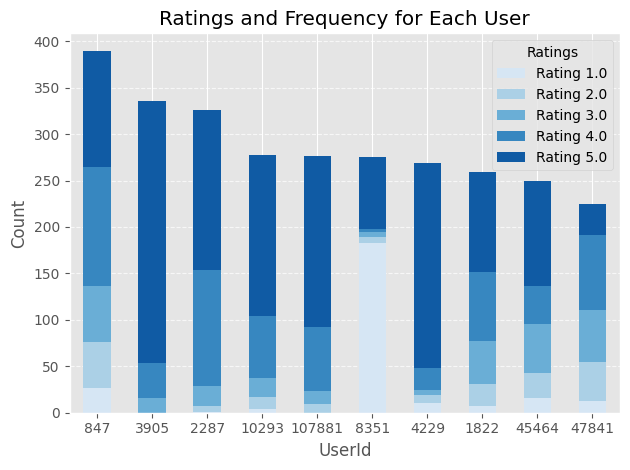

In [ ]:
# Use a blue color palette
colors = sns.color_palette('Blues', n_colors=5)

# Plot the bar chart with a wider figure
plt.figure(figsize=(16, 8))
users_ratings[['Rating 1.0', 'Rating 2.0', 'Rating 3.0', 'Rating 4.0', 'Rating 5.0']].head(10).plot(kind='bar', stacked=True, color=colors)

# Customize the plot
plt.xlabel('UserId')
plt.ylabel('Count')
plt.title('Ratings and Frequency for Each User')
plt.xticks(rotation=0)
plt.legend(title='Ratings', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
def recommend_products(user_id, user_similarity, user_item_matrix):
    # Get the products that the user has not rated yet.
    unrated_products = user_item_matrix.loc[user_id, :].isna()
    unrated_products = unrated_products.index.values

    # Get the top-k similar users.
    k = 5
    similar_users = user_similarity[user_id].argsort()[-k:][::-1]

    # Get the ratings of the unrated products by the similar users.
    similar_user_ratings = user_item_matrix.loc[similar_users, unrated_products]

    # Calculate the weighted average of the ratings.
    recommended_ratings = similar_user_ratings.mean(axis=0)

    # Sort the recommended ratings by descending order.
    recommended_ratings = np.array(recommended_ratings).argsort()[::-1]

    # Return the top-k recommended products.
    return unrated_products[recommended_ratings[:k]]

In [ ]:
amazon_ratings1 = amazon_ratings.head(30000)
amazon_ratings1 = amazon_ratings1.sort_values(by = 'user_id', ascending = True)
amazon_ratings1.head(4)

,UserId,ProductId,Rating,Timestamp,user_id
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200,0
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200,1
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200,2
3,A1WMRR494NWEWV,0733001998,4.0,1382572800,3


In [ ]:
len(amazon_ratings1['ProductId'].unique())

1858

In [ ]:
%%time
user_item_matrix = amazon_ratings1.pivot_table(index='user_id', columns='ProductId', values='Rating', fill_value=0)
user_item_matrix

CPU times: user 487 ms, sys: 479 ms, total: 966 ms
Wall time: 968 ms


ProductId,0205616461,0558925278,0733001998,0737104473,0762451459,1304139212,1304139220,130414089X,130414643X,1304146537,...,B00007KH0O,B00007KQF3,B00007KUSE,B00007L1HG,B00007L1HT,B00007L1IE,B00007L64J,B00007LB75,B00007LVDA,B00007M0CP
user_id,,,,,,,,,,,,,,,,,,,,,
0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
28454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
28455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

user_similarity = cosine_similarity(user_item_matrix, dense_output=False)

In [ ]:
# Calculate item-item similarity matrix (cosine similarity)
item_sim_matrix = np.dot(user_item_matrix.T, user_item_matrix)

In [ ]:
pd.DataFrame(item_sim_matrix)

In [ ]:
pd.DataFrame(user_similarity)

In [ ]:
# Pivot the table to get ratings as columns and count frequency
users_ratings = amazon_ratings1.pivot_table(index='user_id', columns='Rating', aggfunc='size', fill_value=0)

# Add the 'Frequency' column
users_ratings['Frequency'] = users_ratings.sum(axis=1)

# Rename the columns
users_ratings.columns = ['Rating ' + str(col) for col in users_ratings.columns]

# Reset the index to make 'UserId' a regular column
users_ratings = users_ratings.reset_index()

users_ratings = users_ratings.sort_values(by = 'Rating Frequency', ascending = False)

# Set the 'UserId' column as the index
users_ratings.set_index('user_id', inplace=True)

users_ratings.head(10)

In [ ]:
amazon_ratings1['user_id'].value_counts().idxmax()

In [ ]:
# Get the user ID of the user you want to recommend products to.
user_id = amazon_ratings1['user_id'].value_counts().idxmax()

# Recommend products to the user.
recommended_products = recommend_products(int(user_id), user_similarity, user_item_matrix)

# Print the recommended products.
print(recommended_products)

In [ ]:
# Make recommendations for a given user
user_id = amazon_ratings1['user_id'].value_counts().idxmax()
top_n = 3

# Retrieve the items not rated by the user
user_items = amazon_ratings1.loc[amazon_ratings1['user_id'] == user_id, 'ProductId'].tolist()
all_items = amazon_ratings1['ProductId'].unique()
items_to_rate = list(set(all_items) - set(user_items))

# Predict ratings for the items not rated by the user
item_predictions = np.dot(user_item_matrix.loc[user_id], item_sim_matrix) / np.sum(item_sim_matrix, axis=1)

# Get top N item recommendations based on predicted ratings
top_item_indices = np.argsort(item_predictions)[::-1][:top_n]
top_item_recommendations = [all_items[i] for i in top_item_indices]

print(f"Top {top_n} Recommendations for User {user_id}: {top_item_recommendations}")

In [ ]:
def recommend_products(user_id, user_item_matrix):
    # Get the products that the user has not rated yet.
    unrated_products_index = pd.Index(pd.isna(user_item_matrix[user_id]))

    # Predict the ratings for the unrated products.
    predicted_ratings = user_item_matrix.dot(svd.inverse_transform(user_item_matrix[user_id]))

    # Sort the predicted ratings by descending order.
    predicted_ratings = np.array(predicted_ratings).argsort()[::-1]

    # Return the top-k recommended products.
    return user_item_matrix.columns[unrated_products_index][predicted_ratings[:5]]

In [ ]:
# Function to generate recommendations for a user
def generate_recommendations(user_id, top_n):
    user_ratings = user_item_matrix.loc[user_id]
    user_predictions = item_sim_matrix.dot(user_ratings)
    recommended_indices = user_predictions.argsort()[-top_n:][::-1]
    recommended_products = user_item_matrix.columns[recommended_indices]
    return recommended_products

In [ ]:
svd = TruncatedSVD(n_components=100)

# Fit the TruncatedSVD object to the user-item matrix.
user_item_matrix_svd = svd.fit_transform(user_item_matrix)

In [ ]:
pd.DataFrame(user_item_matrix_svd)

In [ ]:
# Get the user ID of the user you want to recommend products to.
user_id = amazon_ratings1['user_id'].value_counts().idxmax()

# Recommend products to the user.
recommended_products = user_item_matrix_svd[user_id].argsort()[::-1][:5]

# Print the recommended products.
print(recommended_products)

In [ ]:
amazon_ratings1.head(3)

In [ ]:
user_id = amazon_ratings1['user_id'].value_counts().idxmax()
top_n = 3

recommendations = generate_recommendations(user_id, top_n)
print(f"Top {top_n} Recommendations for User {user_id}: {recommendations}")

In [ ]:
pd.DataFrame(item_sim_matrix)

In [ ]:
pd.DataFrame(cosine_similarity(user_item_matrix.T))

In [ ]:
pd.DataFrame(user_similarity)

In [ ]:
# Calculate item-item similarity matrix
items_sim_matrix = cosine_similarity(user_item_matrix.T)
pd.DataFrame(items_sim_matrix)

In [ ]:
X = user_item_matrix.T
X1 = X
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
print(decomposed_matrix.shape)
pd.DataFrame(decomposed_matrix)

In [ ]:
correlation_matrix = np.corrcoef(decomposed_matrix)
print(correlation_matrix.shape)
pd.DataFrame(correlation_matrix)

In [ ]:
# Function to generate recommendations for a user
def generate_recommendations(user_id, top_n):
    user_ratings = user_item_matrix.loc[user_id]
    user_predictions = np.dot(item_sim_matrix, user_ratings)
    user_predictions = np.where(user_ratings > 0, -1, user_predictions)  # Set already rated items to -1
    recommended_indices = np.argsort(user_predictions)[-top_n:][::-1]
    recommended_products = user_item_matrix.columns[recommended_indices]
    return recommended_products

In [ ]:
users_ratings.head(10)

In [ ]:
amazon_ratings1['UserId'].value_counts().idxmax()

In [ ]:
amazon_ratings1[amazon_ratings1['UserId'] == amazon_ratings1['UserId'].value_counts().idxmax()].sort_values(by = 'ProductId', ascending = False)

In [ ]:
i = "B00006IGL8"

product_names = list(X.index)
product_ID = product_names.index(i)
print(product_ID)

correlation_product_ID = correlation_matrix[product_ID]
print(correlation_product_ID.shape)

Recommend = list(X.index[correlation_product_ID > 0.95])

# Removes the item already bought by the customer
Recommend.remove(i)

Recommend[0:9]

In [ ]:
# Example usage
user_id = amazon_ratings1['user_id'].value_counts().idxmax()
top_n = 2

recommendations = generate_recommendations(user_id, top_n)
print(f"Recommendations for User {user_id}: {recommendations}")